# Statistical Analysis of BioMoQA Classification Models

This notebook performs comprehensive statistical analysis comparing:
1. BERT model configurations (BCE vs focal, with/without title, different negative sampling)
2. Best BERT model vs baseline models (SVM, Random Forest)
3. Friedman + Nemenyi statistical significance tests


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


In [2]:
## 1. Data Loading and Preprocessing


In [ ]:
# Load all datasets
bert = pd.read_csv('../results/metrics/binary_metrics.csv')

svm_data = pd.read_csv('../results/metrics/svm_metrics.csv')
rf_data = pd.read_csv('../results/metrics/random_forest_metrics.csv')

bert_with_title=bert[bert['with_title']==True]
bert_without_title=bert[bert['with_title']==False]

print("Dataset shapes:")
print(f"BERT without title: {bert_without_title.shape}")
print(f"BERT with title: {bert_with_title.shape}")
print(f"SVM: {svm_data.shape}")
print(f"Random Forest: {rf_data.shape}")


KeyError: False

In [4]:
# Combine BERT datasets and add configuration labels
bert_without_title['config'] = bert_without_title.apply(
    lambda row: f"{row['loss_type']}_no_title_{int(row['nb_added_negs'])}", axis=1
)
bert_with_title['config'] = bert_with_title.apply(
    lambda row: f"{row['loss_type']}_with_title_{int(row['nb_added_negs'])}", axis=1
)

# Combine all BERT data
all_bert_data = pd.concat([bert_without_title, bert_with_title], ignore_index=True)

print("\nUnique BERT configurations:")
print(all_bert_data['config'].unique())
print("\nUnique BERT models:")
print(all_bert_data['model_name'].unique())



Unique BERT configurations:
['BCE_no_title_500' 'focal_no_title_500' 'BCE_with_title_1000'
 'focal_with_title_1000']

Unique BERT models:
['BiomedBERT-abs' 'BiomedBERT-abs-ft' 'roberta-base' 'biobert-v1'
 'bert-base' 'Ensemble']


## 2. Box Plot Comparisons by Configuration

### 2.1 BERT Models by Configuration


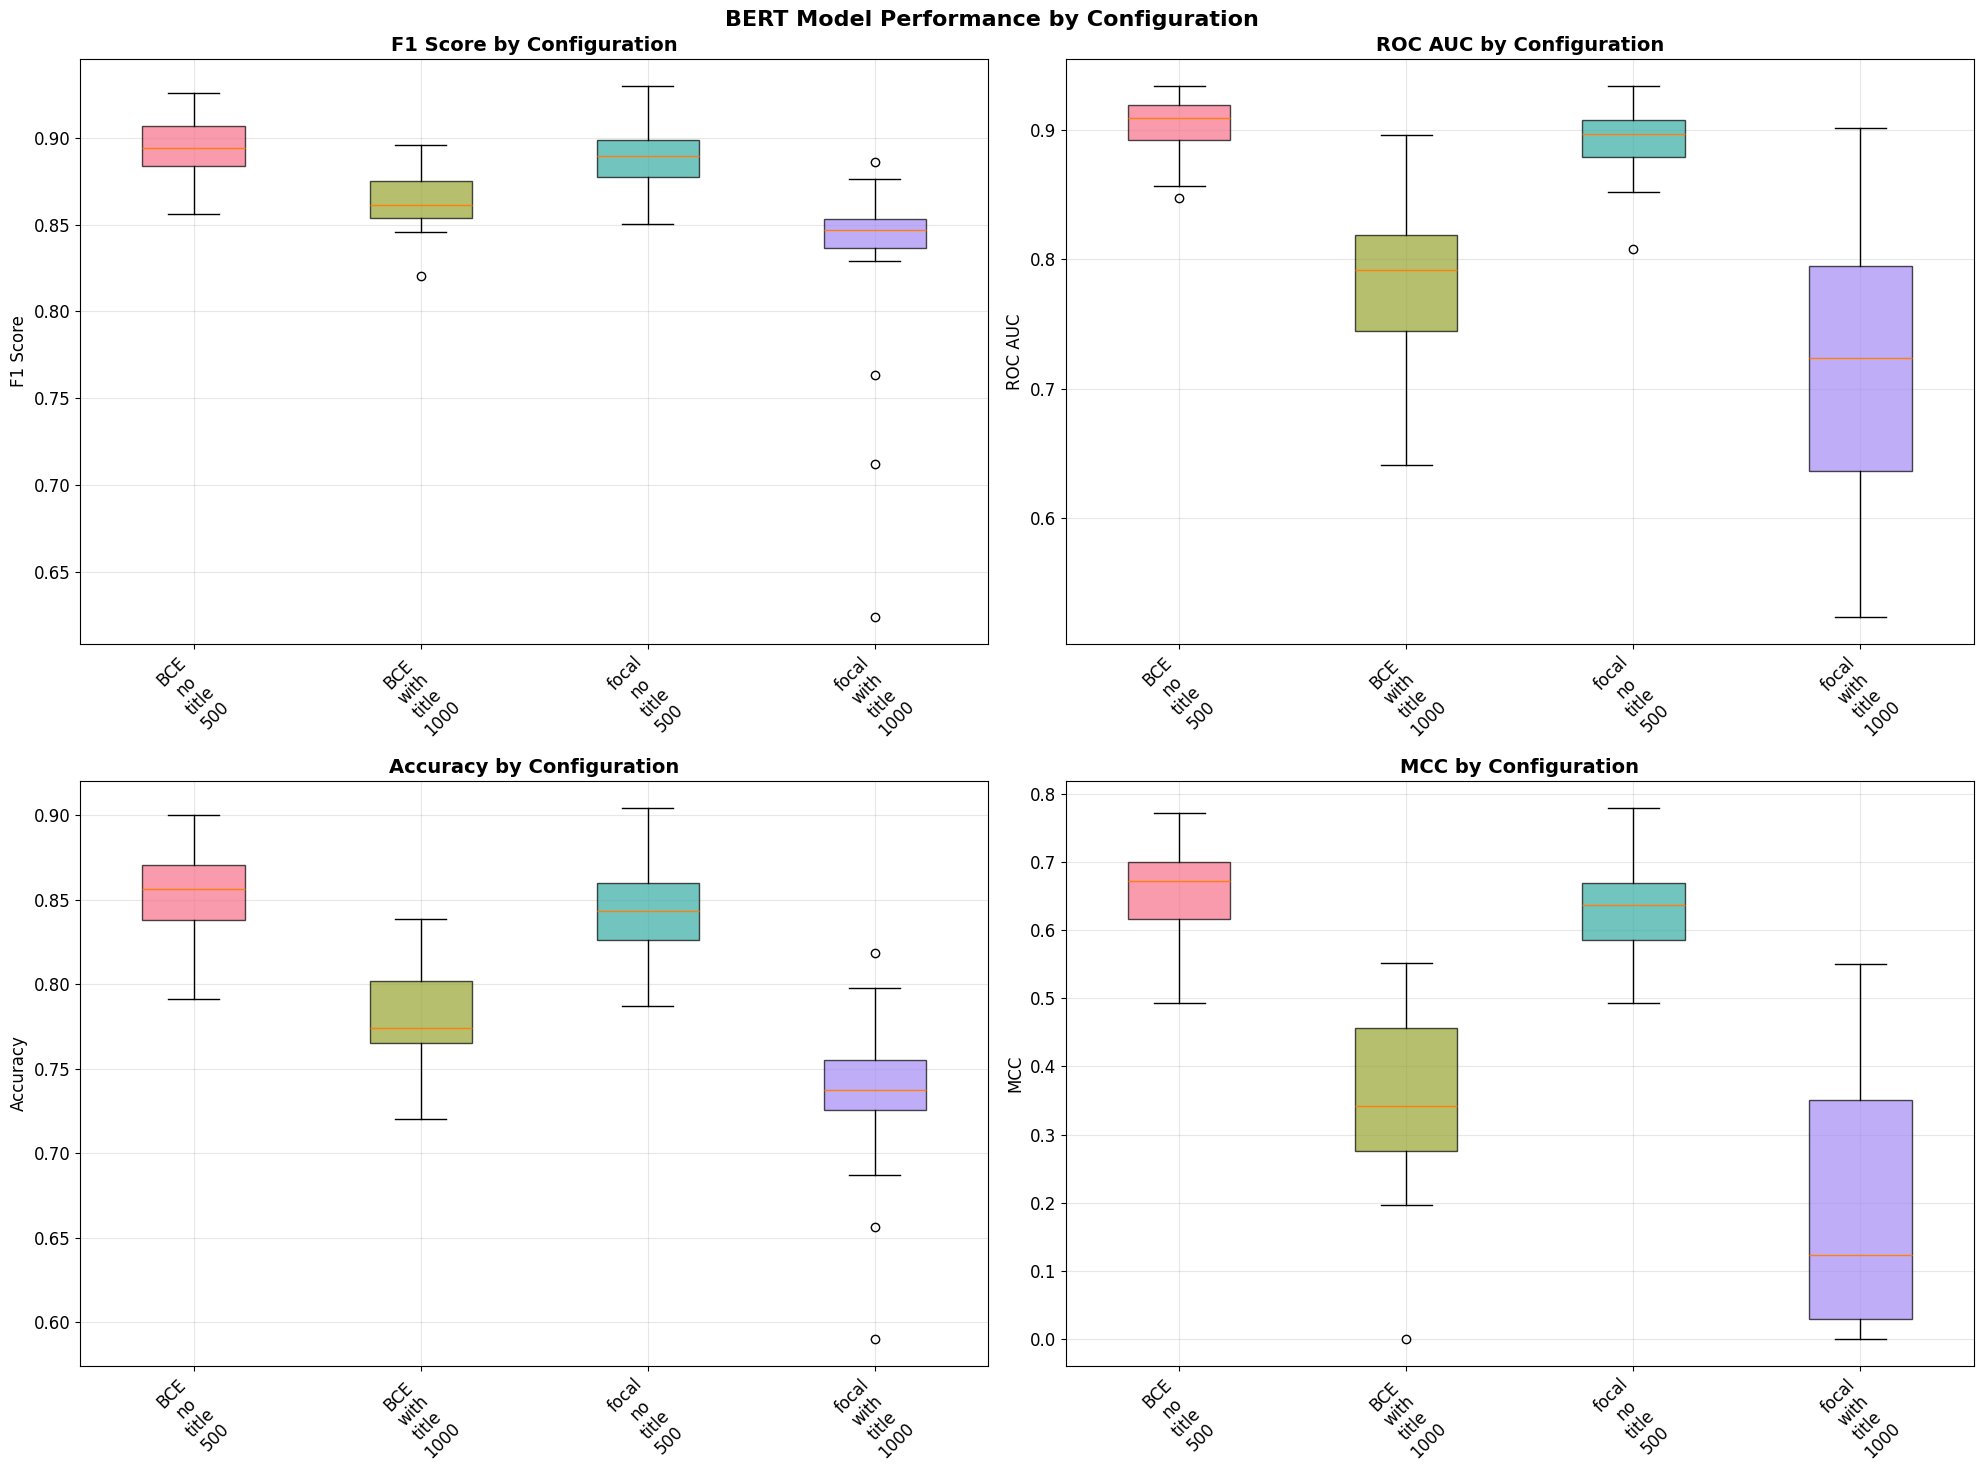

In [5]:
# Create box plots for different BERT configurations
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

metrics = ['f1', 'roc_auc', 'accuracy', 'MCC']
metric_names = ['F1 Score', 'ROC AUC', 'Accuracy', 'MCC']

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i]
    
    # Create box plot
    box_data = []
    labels = []
    
    for config in sorted(all_bert_data['config'].unique()):
        config_data = all_bert_data[all_bert_data['config'] == config][metric].dropna()
        if len(config_data) > 0:
            box_data.append(config_data)
            labels.append(config.replace('_', '\n'))
    
    bp = ax.boxplot(box_data, labels=labels, patch_artist=True)
    
    # Color the boxes
    colors = sns.color_palette("husl", len(box_data))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title(f'{name} by Configuration', fontsize=14, fontweight='bold')
    ax.set_ylabel(name, fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.suptitle('BERT Model Performance by Configuration', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### 2.2 BERT Models by Individual Model Type


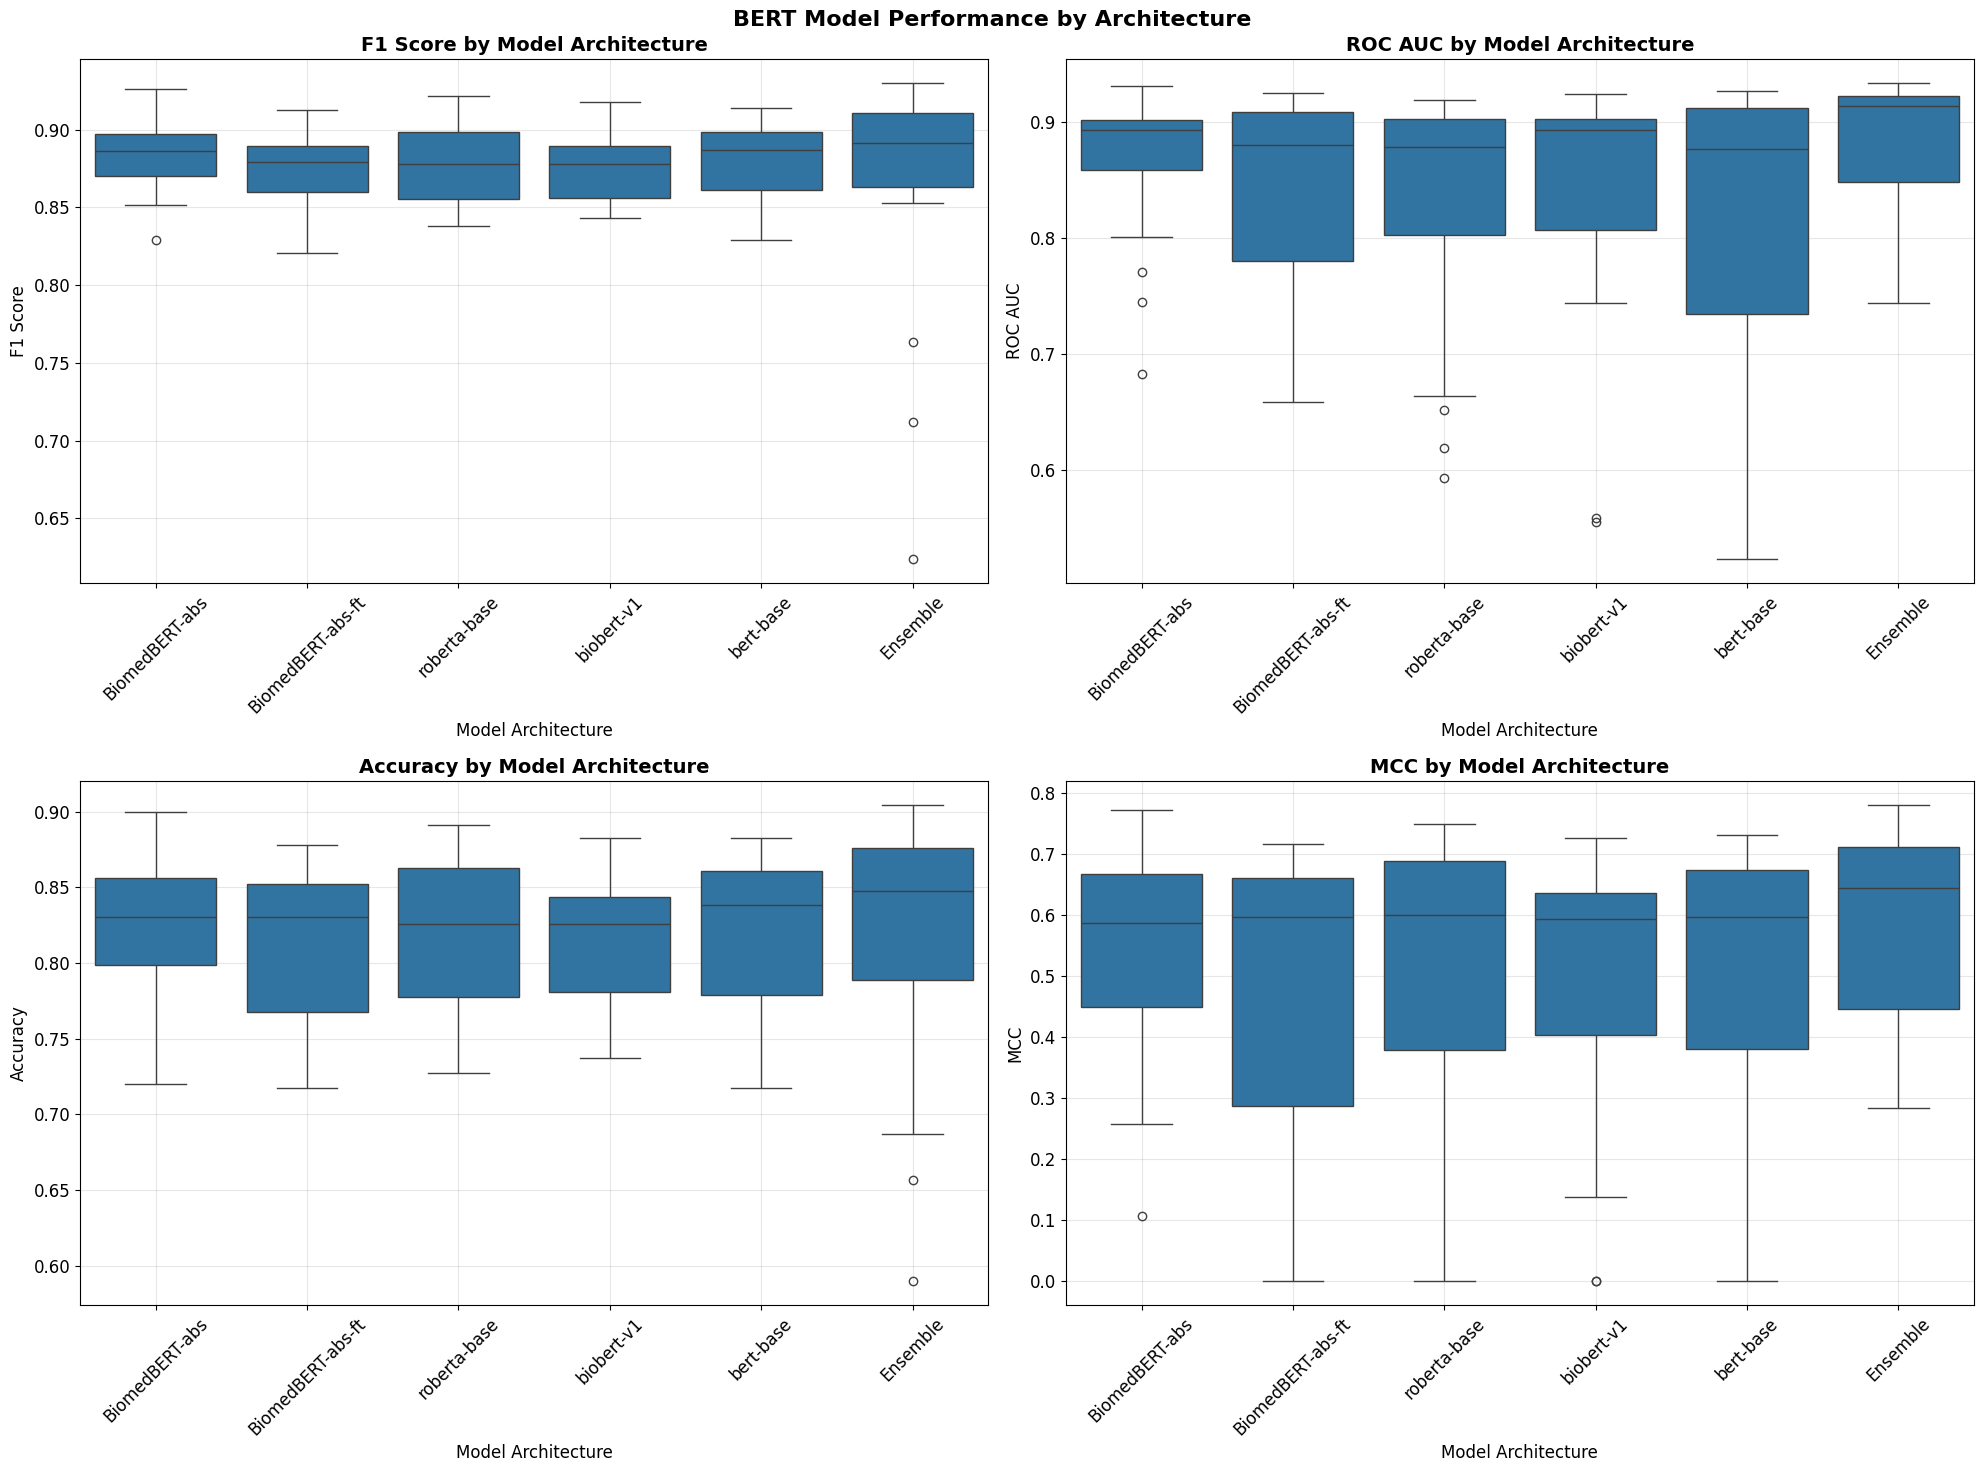

In [6]:
# Box plot comparing different BERT model architectures
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i]
    
    sns.boxplot(data=all_bert_data, x='model_name', y=metric, ax=ax)
    ax.set_title(f'{name} by Model Architecture', fontsize=14, fontweight='bold')
    ax.set_ylabel(name, fontsize=12)
    ax.set_xlabel('Model Architecture', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.suptitle('BERT Model Performance by Architecture', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 3. Best Model Identification


In [7]:
# Find best models for each configuration
def find_best_models_by_config(data, metric='roc_auc'):
    """Find best model for each configuration based on mean performance"""
    best_models = {}
    
    for config in data['config'].unique():
        config_data = data[data['config'] == config]
        
        # Calculate mean performance for each model in this config
        model_means = config_data.groupby('model_name')[metric].mean()
        best_model = model_means.idxmax()
        best_score = model_means.max()
        
        best_models[config] = {
            'model': best_model,
            'mean_score': best_score,
            'std_score': config_data[config_data['model_name'] == best_model][metric].std(),
            'data': config_data[config_data['model_name'] == best_model]
        }
    
    return best_models

# Find best BERT models by configuration
best_bert_by_config = find_best_models_by_config(all_bert_data, 'roc_auc')

print("Best BERT models by configuration (based on ROC AUC score):")
print("=" * 60)
for config, info in best_bert_by_config.items():
    print(f"{config:25} | {info['model']:20} | ROC AUC: {info['mean_score']:.4f} ± {info['std_score']:.4f}")


Best BERT models by configuration (based on ROC AUC score):
BCE_no_title_500          | Ensemble             | ROC AUC: 0.9203 ± 0.0122
focal_no_title_500        | Ensemble             | ROC AUC: 0.9150 ± 0.0144
BCE_with_title_1000       | Ensemble             | ROC AUC: 0.8197 ± 0.0366
focal_with_title_1000     | BiomedBERT-abs       | ROC AUC: 0.8155 ± 0.0950


In [8]:
# Find overall best BERT model
overall_best_score = 0
overall_best_config = None
overall_best_model = None

for config, info in best_bert_by_config.items():
    if info['mean_score'] > overall_best_score:
        overall_best_score = info['mean_score']
        overall_best_config = config
        overall_best_model = info['model']

print(f"\nOverall best BERT model:")
print(f"Configuration: {overall_best_config}")
print(f"Model: {overall_best_model}")
print(f"Mean F1 Score: {overall_best_score:.4f}")

# Get the best BERT model data
best_bert_data = best_bert_by_config[overall_best_config]['data']



Overall best BERT model:
Configuration: BCE_no_title_500
Model: Ensemble
Mean F1 Score: 0.9203


In [9]:
# Find best SVM and Random Forest models
def find_best_baseline_model(data, model_type, metric='f1'):
    """Find best baseline model configuration"""
    if model_type == 'SVM':
        # Group by kernel and other parameters
        group_cols = ['kernel']
    else:  # Random Forest
        # Group by criterion and num_trees
        group_cols = ['criterion', 'num_trees']
    
    # Calculate mean performance for each configuration
    config_means = data.groupby(group_cols)[metric].mean()
    best_config = config_means.idxmax()
    best_score = config_means.max()
    
    # Get data for best configuration
    if model_type == 'SVM':
        best_data = data[data['kernel'] == best_config]
        config_str = f"kernel={best_config}"
    else:
        best_data = data[(data['criterion'] == best_config[0]) & 
                        (data['num_trees'] == best_config[1])]
        config_str = f"criterion={best_config[0]}, num_trees={best_config[1]}"
    
    return {
        'config': config_str,
        'mean_score': best_score,
        'std_score': best_data[metric].std(),
        'data': best_data
    }

# Find best baseline models
best_svm = find_best_baseline_model(svm_data, 'SVM', 'f1')
best_rf = find_best_baseline_model(rf_data, 'Random Forest', 'f1')

print("\nBest baseline models (based on F1 score):")
print("=" * 50)
print(f"SVM     | {best_svm['config']:30} | F1: {best_svm['mean_score']:.4f} ± {best_svm['std_score']:.4f}")
print(f"RF      | {best_rf['config']:30} | F1: {best_rf['mean_score']:.4f} ± {best_rf['std_score']:.4f}")



Best baseline models (based on F1 score):
SVM     | kernel=sigmoid                 | F1: 0.8184 ± 0.0147
RF      | criterion=gini, num_trees=800  | F1: 0.8141 ± 0.0234


In [10]:
## 4. Best Model vs Baselines Comparison


In [11]:
# Compare best BERT model with best baselines
comparison_data = {
    'Model': [],
    'F1': [],
    'ROC_AUC': [],
    'Accuracy': [],
    'MCC': [],
    'Fold': []
}

# Add best BERT data
for _, row in best_bert_data.iterrows():
    comparison_data['Model'].append(f'BERT\n({overall_best_model})')
    comparison_data['F1'].append(row['f1'])
    comparison_data['ROC_AUC'].append(row['roc_auc'])
    comparison_data['Accuracy'].append(row['accuracy'])
    comparison_data['MCC'].append(row['MCC'])
    comparison_data['Fold'].append(row['fold'])

# Add best SVM data
for _, row in best_svm['data'].iterrows():
    comparison_data['Model'].append('SVM')
    comparison_data['F1'].append(row['f1'])
    comparison_data['ROC_AUC'].append(row['roc_auc'] if 'roc_auc' in row else 0)
    comparison_data['Accuracy'].append(row['accuracy'])
    comparison_data['MCC'].append(row['MCC'])
    comparison_data['Fold'].append(row['fold'])

# Add best RF data
for _, row in best_rf['data'].iterrows():
    comparison_data['Model'].append('Random Forest')
    comparison_data['F1'].append(row['f1'])
    comparison_data['ROC_AUC'].append(row['roc_auc'] if 'roc_auc' in row else 0)
    comparison_data['Accuracy'].append(row['accuracy'])
    comparison_data['MCC'].append(row['MCC'])
    comparison_data['Fold'].append(row['fold'])

comparison_df = pd.DataFrame(comparison_data)


ValueError: Unable to parse string "{}" at position 10

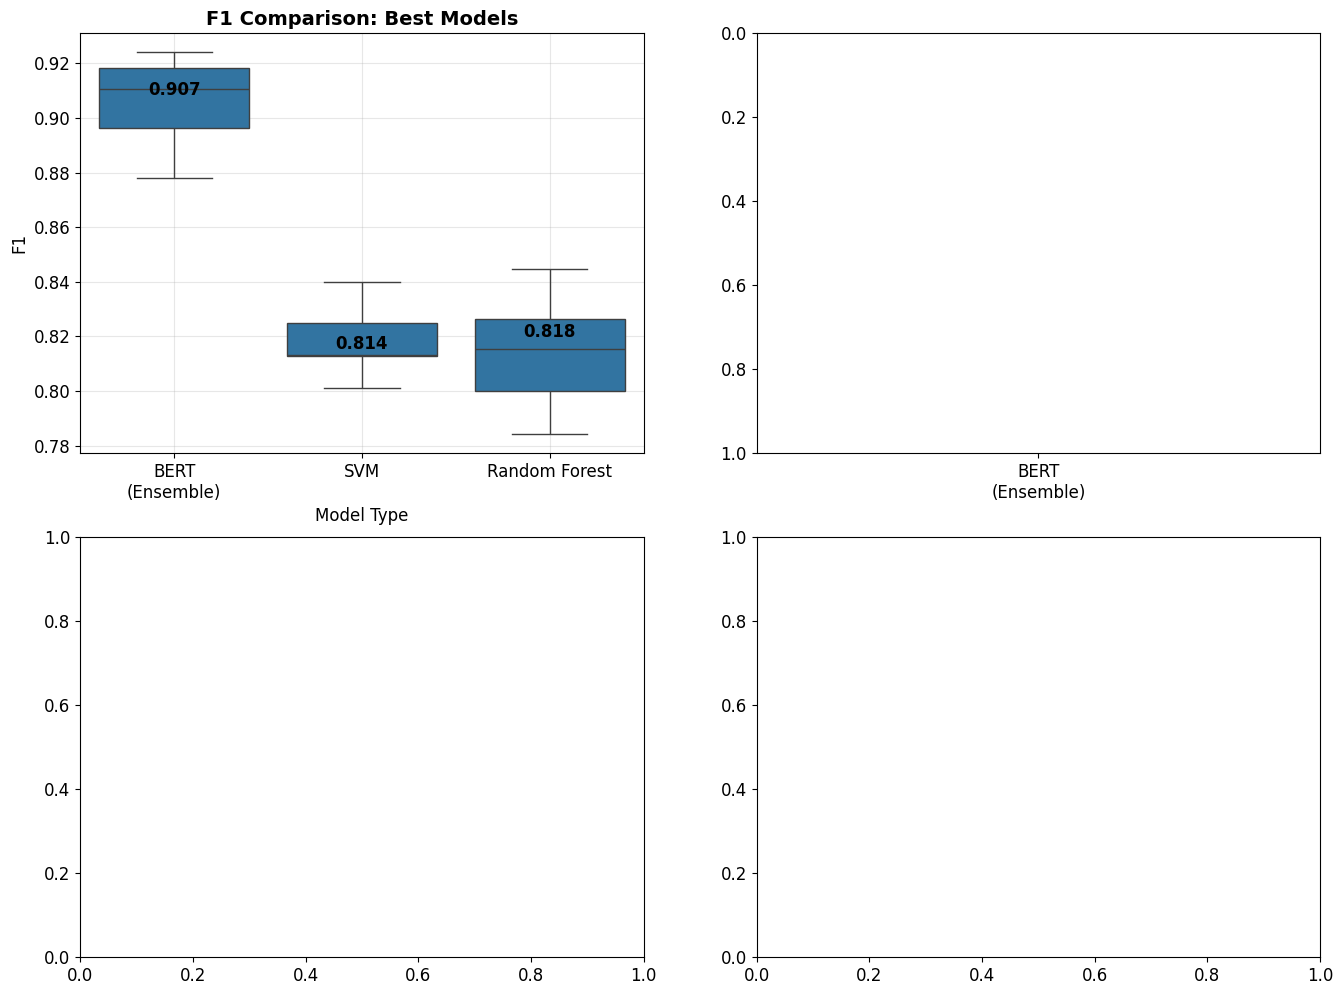

In [12]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

comparison_metrics = ['F1', 'ROC_AUC', 'Accuracy', 'MCC']
for i, metric in enumerate(comparison_metrics):
    ax = axes[i]
    
    sns.boxplot(data=comparison_df, x='Model', y=metric, ax=ax)
    ax.set_title(f'{metric} Comparison: Best Models', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('Model Type', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add mean values as text
    means = comparison_df.groupby('Model')[metric].mean()
    for j, (model, mean_val) in enumerate(means.items()):
        ax.text(j, mean_val, f'{mean_val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Performance Comparison: Best BERT vs Best Baselines', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
## 5. Statistical Significance Testing

### 5.1 Friedman Test + Nemenyi Post-hoc for BERT Configurations


In [ ]:
# Prepare data for Friedman test - best model from each configuration
friedman_data = []
config_names = []
fold_info = []

# Get performance for each fold for the best model from each configuration
for config, info in best_bert_by_config.items():
    config_data = info['data'].sort_values('fold')
    f1_scores = config_data['f1'].values
    
    if len(f1_scores) >= 4:  # Ensure we have data for all folds
        friedman_data.append(f1_scores)
        config_names.append(config)
        fold_info.append(config_data[['fold', 'f1']].copy())

print(f"Configurations included in Friedman test: {len(config_names)}")
for i, name in enumerate(config_names):
    print(f"{i+1:2d}. {name} (n={len(friedman_data[i])})")


Configurations included in Friedman test: 3
 1. focal_no_title_1000 (n=4)
 2. BCE_with_title_1000 (n=4)
 3. focal_with_title_1000 (n=4)


In [ ]:
# Perform Friedman test
if len(friedman_data) >= 3:
    friedman_stat, friedman_p = friedmanchisquare(*friedman_data)
    
    print("\nFriedman Test Results:")
    print("=" * 30)
    print(f"Test statistic: {friedman_stat:.4f}")
    print(f"P-value: {friedman_p:.6f}")
    print(f"Significant (α=0.05): {'Yes' if friedman_p < 0.05 else 'No'}")
    
    # If significant, perform Nemenyi post-hoc test
    if friedman_p < 0.05:
        print("\nPerforming Nemenyi post-hoc test...")
        
        # Prepare data for post-hoc test
        posthoc_data = np.array(friedman_data).T  # Transpose for correct format
        
        # Perform Nemenyi test
        nemenyi_result = sp.posthoc_nemenyi_friedman(posthoc_data)
        
        # Create a more readable result with configuration names
        nemenyi_result.index = [name.replace('_', ' ') for name in config_names]
        nemenyi_result.columns = [name.replace('_', ' ') for name in config_names]
        
        print("\nNemenyi Post-hoc Test Results (p-values):")
        print(nemenyi_result.round(4))
        
        # Visualize the results
        plt.figure(figsize=(12, 10))
        sns.heatmap(nemenyi_result, annot=True, cmap='RdYlBu_r', center=0.05, 
                   square=True, linewidths=0.5, cbar_kws={"shrink": .8})
        plt.title('Nemenyi Post-hoc Test Results\n(p-values for pairwise comparisons)', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Configuration', fontsize=12)
        plt.ylabel('Configuration', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Count significant differences
        significant_pairs = 0
        total_pairs = 0
        for i in range(len(config_names)):
            for j in range(i+1, len(config_names)):
                p_val = nemenyi_result.iloc[i, j]
                if p_val < 0.05:
                    significant_pairs += 1
                total_pairs += 1
        
        print(f"\nSignificant pairwise differences: {significant_pairs}/{total_pairs}")
        print(f"Percentage of significant pairs: {(significant_pairs/total_pairs)*100:.1f}%")
    
else:
    print("Not enough configurations for Friedman test (minimum 3 required)")



Friedman Test Results:
Test statistic: 3.5000
P-value: 0.173774
Significant (α=0.05): No


In [ ]:
### 5.2 Statistical Test for Best Models (BERT vs Baselines)


In [ ]:
# Prepare data for comparing best models
best_models_comparison = {
    'BERT': best_bert_data['f1'].values,
    'SVM': best_svm['data']['f1'].values,
    'Random Forest': best_rf['data']['f1'].values
}

# Ensure all have the same number of samples (folds)
min_samples = min(len(scores) for scores in best_models_comparison.values())
for model_type in best_models_comparison:
    best_models_comparison[model_type] = best_models_comparison[model_type][:min_samples]

print("Best Models Comparison Data:")
for model_type, scores in best_models_comparison.items():
    print(f"{model_type:15} | Mean F1: {np.mean(scores):.4f} ± {np.std(scores):.4f} (n={len(scores)})")

# Perform Friedman test for best models
if len(best_models_comparison) >= 3 and min_samples >= 3:
    friedman_stat_best, friedman_p_best = friedmanchisquare(
        *list(best_models_comparison.values())
    )
    
    print("\nFriedman Test Results (Best Models):")
    print("=" * 40)
    print(f"Test statistic: {friedman_stat_best:.4f}")
    print(f"P-value: {friedman_p_best:.6f}")
    print(f"Significant (α=0.05): {'Yes' if friedman_p_best < 0.05 else 'No'}")
    
    if friedman_p_best < 0.05:
        # Post-hoc test for best models
        posthoc_data_best = np.array(list(best_models_comparison.values())).T
        nemenyi_result_best = sp.posthoc_nemenyi_friedman(posthoc_data_best)
        
        nemenyi_result_best.index = list(best_models_comparison.keys())
        nemenyi_result_best.columns = list(best_models_comparison.keys())
        
        print("\nNemenyi Post-hoc Test Results (Best Models):")
        print(nemenyi_result_best.round(4))
        
        # Visualize
        plt.figure(figsize=(8, 6))
        sns.heatmap(nemenyi_result_best, annot=True, cmap='RdYlBu_r', center=0.05,
                   square=True, linewidths=1, cbar_kws={"shrink": .8})
        plt.title('Nemenyi Test: Best Models Comparison\n(p-values)', 
                 fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("\nInsufficient data for statistical test of best models")


Best Models Comparison Data:
BERT            | Mean F1: 0.8847 ± 0.0071 (n=3)
SVM             | Mean F1: 0.8620 ± 0.0232 (n=3)
Random Forest   | Mean F1: 0.8476 ± 0.0022 (n=3)

Friedman Test Results (Best Models):
Test statistic: 2.6667
P-value: 0.263597
Significant (α=0.05): No


In [ ]:
## 6. Summary and Rankings


In [ ]:
# Create summary table of all configurations
summary_data = []

# Add BERT configurations
for config, info in best_bert_by_config.items():
    summary_data.append({
        'Model Type': 'BERT',
        'Configuration': config,
        'Best Model': info['model'],
        'Mean F1': info['mean_score'],
        'Std F1': info['std_score'],
        'Mean ROC AUC': info['data']['roc_auc'].mean(),
        'Mean Accuracy': info['data']['accuracy'].mean(),
        'Mean MCC': info['data']['MCC'].mean()
    })

# Add baseline models
summary_data.append({
    'Model Type': 'SVM',
    'Configuration': best_svm['config'],
    'Best Model': 'SVM',
    'Mean F1': best_svm['mean_score'],
    'Std F1': best_svm['std_score'],
    'Mean ROC AUC': best_svm['data']['roc_auc'].mean() if 'roc_auc' in best_svm['data'] else 0,
    'Mean Accuracy': best_svm['data']['accuracy'].mean(),
    'Mean MCC': best_svm['data']['MCC'].mean()
})

summary_data.append({
    'Model Type': 'Random Forest',
    'Configuration': best_rf['config'],
    'Best Model': 'Random Forest',
    'Mean F1': best_rf['mean_score'],
    'Std F1': best_rf['std_score'],
    'Mean ROC AUC': best_rf['data']['roc_auc'].mean() if 'roc_auc' in best_rf['data'] else 0,
    'Mean Accuracy': best_rf['data']['accuracy'].mean(),
    'Mean MCC': best_rf['data']['MCC'].mean()
})

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Mean F1', ascending=False).reset_index(drop=True)

print("\n" + "=" * 120)
print("FINAL RANKING - ALL MODELS AND CONFIGURATIONS")
print("=" * 120)
print(summary_df.round(4).to_string(index=False))



FINAL RANKING - ALL MODELS AND CONFIGURATIONS
   Model Type                 Configuration     Best Model  Mean F1  Std F1  Mean ROC AUC  Mean Accuracy  Mean MCC
          SVM                   kernel=poly            SVM   0.8606  0.0177        0.0000         0.7741    0.3235
         BERT             BCE_no_title_1000     biobert-v1   0.8604  0.0435        0.8604         0.8182    0.4856
Random Forest criterion=gini, num_trees=100  Random Forest   0.8495  0.0086        0.0000         0.7574    0.2719
         BERT           BCE_with_title_1000       Ensemble   0.8197  0.0366        0.8197         0.7859    0.3630
         BERT         focal_with_title_1000 BiomedBERT-abs   0.8155  0.0950        0.8155         0.7835    0.3537
         BERT           focal_no_title_1000 BiomedBERT-abs   0.7334  0.0736        0.7334         0.7652    0.2770


In [ ]:
# Highlight top 3
print("\n" + "=" * 50)
print("TOP 3 PERFORMERS:")
print("=" * 50)
for i in range(min(3, len(summary_df))):
    row = summary_df.iloc[i]
    print(f"{i+1}. {row['Model Type']} - {row['Configuration']}")
    print(f"   Model: {row['Best Model']}")
    print(f"   F1: {row['Mean F1']:.4f} ± {row['Std F1']:.4f}")
    print(f"   Accuracy: {row['Mean Accuracy']:.4f}")
    print(f"   MCC: {row['Mean MCC']:.4f}")
    print()

print("STATISTICAL ANALYSIS SUMMARY")
print("=" * 60)

print("\n1. BEST OVERALL PERFORMANCE:")
best_overall = summary_df.iloc[0]
print(f"   Model: {best_overall['Model Type']} - {best_overall['Best Model']}")
print(f"   Configuration: {best_overall['Configuration']}")
print(f"   F1 Score: {best_overall['Mean F1']:.4f} ± {best_overall['Std F1']:.4f}")

print("\n2. CONFIGURATION ANALYSIS:")
bert_configs = summary_df[summary_df['Model Type'] == 'BERT']
best_bert_config = bert_configs.iloc[0]
print(f"   Best BERT configuration: {best_bert_config['Configuration']}")
print(f"   Best BERT model: {best_bert_config['Best Model']}")

# Performance improvement over baselines
svm_f1 = summary_df[summary_df['Model Type'] == 'SVM']['Mean F1'].iloc[0]
rf_f1 = summary_df[summary_df['Model Type'] == 'Random Forest']['Mean F1'].iloc[0]
best_bert_f1 = best_bert_config['Mean F1']

svm_improvement = ((best_bert_f1 - svm_f1) / svm_f1) * 100
rf_improvement = ((best_bert_f1 - rf_f1) / rf_f1) * 100

print("\n3. PERFORMANCE IMPROVEMENTS:")
print(f"   Best BERT vs SVM: +{svm_improvement:.2f}% improvement")
print(f"   Best BERT vs Random Forest: +{rf_improvement:.2f}% improvement")

print("\n4. RECOMMENDATIONS:")
print(f"   • Use {best_overall['Best Model']} with {best_overall['Configuration']}")
print(f"   • Expected F1 performance: {best_overall['Mean F1']:.4f} ± {best_overall['Std F1']:.4f}")
print(f"   • This configuration shows superior performance over baseline methods")

print("\n" + "=" * 60)



TOP 3 PERFORMERS:
1. SVM - kernel=poly
   Model: SVM
   F1: 0.8606 ± 0.0177
   Accuracy: 0.7741
   MCC: 0.3235

2. BERT - BCE_no_title_1000
   Model: biobert-v1
   F1: 0.8604 ± 0.0435
   Accuracy: 0.8182
   MCC: 0.4856

3. Random Forest - criterion=gini, num_trees=100
   Model: Random Forest
   F1: 0.8495 ± 0.0086
   Accuracy: 0.7574
   MCC: 0.2719

STATISTICAL ANALYSIS SUMMARY

1. BEST OVERALL PERFORMANCE:
   Model: SVM - SVM
   Configuration: kernel=poly
   F1 Score: 0.8606 ± 0.0177

2. CONFIGURATION ANALYSIS:
   Best BERT configuration: BCE_no_title_1000
   Best BERT model: biobert-v1

3. PERFORMANCE IMPROVEMENTS:
   Best BERT vs SVM: +-0.02% improvement
   Best BERT vs Random Forest: +1.28% improvement

4. RECOMMENDATIONS:
   • Use SVM with kernel=poly
   • Expected F1 performance: 0.8606 ± 0.0177
   • This configuration shows superior performance over baseline methods

